# Elo Rating Tennis Match Prediction

This project uses Elo ratings to predict the outcome of tennis matches.

## Table of Contents

1. [Introduction](#1)
2. [Data Manipulation](#2)
3. [Elo Ratings](#3)
    1. [Initial Elo Ratings](#4)
4. [Game Differential](#5)
5. [Win Margin Multiplier](#6)
    1. [Natural Logarithm Multiplier](#7)
        1. [Optimal Denominator](#8)
    2. [Nearly Linear Multiplier](#9)
        1. [Optimal Denominator](#10)
6. [Functions for Elo Rating](#11)
    1. [Probability of Winning](#12)
    2. [Update Elo Rating](#13)
    3. [Win Multiplier](#14)
    4. [K-Factor](#15)
    5. [Calculate Elo Rating](#16)
7. [Evaluate Prediction Accuracy](#17)
8. [Cross-Validation](#18)
9. [Fill in Missing Ratings](#19)
10. [Tune Win Multiplier](#20)
11. [Optimal Win Multiplier](#21)
12. [Make Predictions](#22)
13. [Future Applications](#23)
    1. [Time Series Approach](#24)
    2. [Percentage of Games Won](#25)
    3. [TrueSkill Ranking](#26)
    4. [Glicko Rating](#27)
15. [References](#28)

<a id="1"></a> <br>
## Introduction

The goal of the project is to accurately predict upcoming tennis matches. The data consists of 2019 singles tennis results split randomly (~70% for training, ~30% for testing). Elo ratings are used to evaluate the strength and ranking of each player which is then used to predict the probability that player 1 will win the matches in the testing data. A win margin multplier has been added to the Elo rating functions to account for the difference in the number of games won by each player. Multiple win multipliers were tested using cross-validation and hyperparameter tuning. Using k-fold cross-validation, the original 70% training data is split further into training and testing folds while the original 30% testing data is used as the evaluation data. The optimal win multiplier uses a natural logarithm function and was used to get the probability of player 1 winning in the evaluation data.

<a id="2"></a> <br>
## Data Manipulation

Prior to beginning our analysis we have to do some basic data manipulation. A new column is created to calculate the number of games that the winner won, and the number of games that the loser won. This will be used to calculate the difference in games won in the match, which will later be used in our calculation of Elo ratings. For simplicity, we do not need to worry about the number of games won in each set. We can use the total number of games won by each player for our Elo rating calculations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
from sklearn.model_selection import train_test_split

# Sets path where data is stored
data_path = '/Users/bradklassen/GitHub/elo-rating-tennis-predictions/'

# Read in training data and evaluation data
data = pd.read_csv(f'{data_path}training_data.csv')
evaluation_data = pd.read_csv(f'{data_path}testing_data.csv')


def game_differential(df):
    """
    Add four new columns.
     "winner_games" - Number of games won in entire match for winner.
     "loser_games" - Number of games won in entire match for loser.
     "total_games" - Total games played in the match.
     "game_differential" - Difference in games won between the winner and loser.

        Parameters:
            df (pd.DataFrame): Original data set.

        Returns:
            df (pd.DataFrame): Data set with added columns.
    """

    # Calculate number of games won in entire match for winner
    df['winner_games'] = df['winner_set_1'] + df['winner_set_2'] + df['winner_set_3'] + df['winner_set_4'] + \
                         df['winner_set_5']

    # Calculate number of games won in entire match for loser
    df['loser_games'] = df['loser_set_1'] + df['loser_set_2'] + df['loser_set_3'] + df['loser_set_4'] + \
                        df['loser_set_5']

    # Total games played in match
    df['total_games'] = df['winner_games'] + df['loser_games']

    # The difference in games won between the winner and loser of the match
    df['game_differential'] = abs(df['winner_games'] - df['loser_games'])

    return df

<a id="3"></a> <br>
## Elo Rating

Elo ratings are used to calculate the relative skill levels of players in zero-sum games such as tennis. The Elo rating will change as the athlete plays more games. Players with more matches played will have a more accurate rating. If a players match score exceeds their predicted score, their rating increases, if it falls short of their expected score, their rating decreases.

<a id="4"></a> <br>
### Initial Elo Ratings

Elo ratings start at 1500 for each player and will be changed after games are played.

In [2]:
def initialize_elo(df):
    """
    Initialize Elo ratings as 1500 for all players.

        Parameters:
            df (pd.DataFrame): Data set.

        Returns:
            elo_rating (pd.DataFrame): Data set of players Elo ratings.
            starting_elo (dict): Dictionary with player id and their Elo rating.
    """

    # Get all unique player ids in data set
    unique_player_ids = set(list(df['winner_id'].unique()) + list(df['loser_id'].unique()))

    # Initial Elo ratings for each player
    elo_dict = {'player_id': list(unique_player_ids), 'rating': [1500] * len(unique_player_ids)}

    # Create dictionary with Player ID and their Elo rating
    starting_elo = dict(zip(elo_dict['player_id'], elo_dict['rating']))

    # Create DataFrame of Elo ratings
    elo_rating = pd.DataFrame(elo_dict)

    return elo_rating, starting_elo

<a id="5"></a> <br>
## Game Differential
We will now explore introducing a win multiplier to account for how close the match was. We will first start by getting an understanding of the distribution of the game win differential. This will be used to add a multiplier to a match based on the difference in games won.

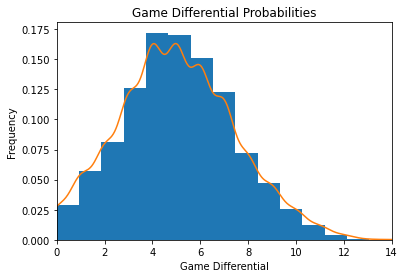

In [3]:
# Run game_differential function
data = game_differential(data)

# Initialize plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram
data['game_differential'].plot(kind='hist', density=True, bins=data['game_differential'].nunique())

# Kernel Density Estimation (KDE) computes underlying distribution
data['game_differential'].plot(kind='kde')

# Set X label
ax.set_xlabel('Game Differential')

# Set range of X-axis
ax.set_xlim(data['game_differential'].min(), data['game_differential'].max())

# Change Y label
ax.set_ylabel('Frequency')

# Set plot title
ax.set_title('Game Differential Probabilities')

# Display title
plt.show()

<a id="6"></a> <br>
## Win Margin Multiplier

The win margin multplier originates from a Nate Silver interview discussing win margin in Elo rating. [1] 

There are multiple ways to add a win multiplier to a match. Two popular methods include a nearly linear model and a natural logarithm model. Famous statistician Nate Silver uses a natural logarithm function for his NFL Elo ratings, and a nearly linear function for his NBA Elo ratings. We will test both of them below.

<a id="7"></a> <br>
## Natural Logarithm Multiplier

Below we will explore a function using a natural logarithm. The denominator of the function has been tuned to analyze the difference it makes in the multiplier.

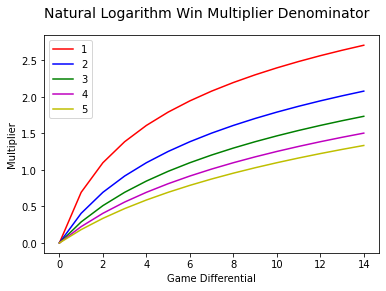

Win Multiplier When x Equals the Mean Game Differential:
Denominator = 1: 1.7912467426099739
Denominator = 2: 1.2523235046341972
Denominator = 3: 0.9804447326960762
Denominator = 4: 0.810588427682448
Denominator = 5: 0.6928395761368049


In [4]:
# Average game differential
game_diff_mean = data['game_differential'].mean()

fig, ax = plt.subplots(figsize=(6, 4))

x = np.array(range(data['game_differential'].min(), data['game_differential'].max() + 1))
a = np.log((x/1) + 1)
b = np.log((x/2) + 1)
c = np.log((x/3) + 1)
d = np.log((x/4) + 1)
e = np.log((x/5) + 1)

ax.plot(x, a, 'r', label='1')
ax.plot(x, b, 'b', label='2')
ax.plot(x, c, 'g', label='3')
ax.plot(x, d, 'm', label='4')
ax.plot(x, e, 'y', label='5')

fig.suptitle('Natural Logarithm Win Multiplier Denominator', fontsize=14)
plt.xlabel('Game Differential', fontsize=10)
plt.ylabel('Multiplier', fontsize=10)

plt.legend(loc='upper left')

plt.show()

print('Win Multiplier When x Equals the Mean Game Differential:')
print(f'Denominator = 1: {np.log((game_diff_mean/1) + 1)}')
print(f'Denominator = 2: {np.log((game_diff_mean/2) + 1)}')
print(f'Denominator = 3: {np.log((game_diff_mean/3) + 1)}')
print(f'Denominator = 4: {np.log((game_diff_mean/4) + 1)}')
print(f'Denominator = 5: {np.log((game_diff_mean/5) + 1)}')

<a id="8"></a> <br>
#### Optimal Denominator

Prior to cross validation we will get an idea of an acceptable denominator value by solving the function for the denominator when the numerator is equal to the mean of the game differential and the equation is equal to 1.

In [5]:
"""
Solve for x, ln((game_diff_mean/x) + 1) = 1:

1. Take exponential of both sides
   (game_diff_mean/x) + 1 = e^1

2. Multiply both sides by x
   game_diff_mean + x = e^1 * x

3. Get x on its own
   x = game_diff_mean / e^1 - 1
"""

# Optimal ln denominator
ln_optimal_denominator = game_diff_mean / (math.exp(1) - 1)

print(f'Optimal Denominator Value of Natural Logarithm Win Multiplier: {ln_optimal_denominator}')

Optimal Denominator Value of Natural Logarithm Win Multiplier: 2.908093623561006


When the denominator of the natural logarithm equation equals the above optimal denominator, the win multiplier equals 1, given that the numerator in the equation is the mean of the game differential (4.9969).

<a id="9"></a> <br>
## Nearly Linear Multiplier

A second possible win multiplier uses a nearly linear function. When comparing the
linear function to the natural logarithm function, the variation in the multipliers
is significantly larger.

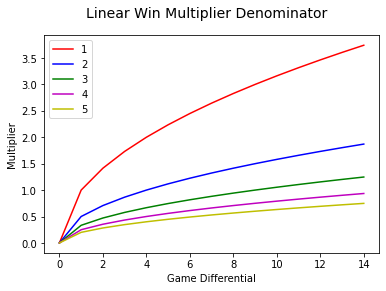

Win Multiplier When x Equals the Mean Game Differential:
Denominator = 1: 2.2353801530886184
Denominator = 2: 1.1176900765443092
Denominator = 3: 0.7451267176962061
Denominator = 4: 0.5588450382721546
Denominator = 5: 0.44707603061772366


In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

x = np.array(range(data['game_differential'].min(), data['game_differential'].max() + 1))
a = ((x ** 0.5) / 1)
b = ((x ** 0.5) / 2)
c = ((x ** 0.5) / 3)
d = ((x ** 0.5) / 4)
e = ((x ** 0.5) / 5)

ax.plot(x, a, 'r', label='1')
ax.plot(x, b, 'b', label='2')
ax.plot(x, c, 'g', label='3')
ax.plot(x, d, 'm', label='4')
ax.plot(x, e, 'y', label='5')

fig.suptitle('Linear Win Multiplier Denominator', fontsize=14)
plt.xlabel('Game Differential', fontsize=10)
plt.ylabel('Multiplier', fontsize=10)

plt.legend(loc='upper left')

plt.show()

print('Win Multiplier When x Equals the Mean Game Differential:')
print(f'Denominator = 1: {((game_diff_mean ** 0.5) / 1)}')
print(f'Denominator = 2: {((game_diff_mean ** 0.5) / 2)}')
print(f'Denominator = 3: {((game_diff_mean ** 0.5) / 3)}')
print(f'Denominator = 4: {((game_diff_mean ** 0.5) / 4)}')
print(f'Denominator = 5: {((game_diff_mean ** 0.5) / 5)}')

<a id="10"></a> <br>
#### Optimal Denominator

Similar to above, prior to cross validation we will get an idea of an acceptable denominator value by solving the function for the denominator when the numerator is equal to the mean of the game differential and the equation is equal to 1.

In [7]:
"""
Solve for x, ((game_diff_mean ** 0.5) / x) = 1:

1. Multiply both sides by x
   game_diff_mean^0.5 = x

2. Square root LHS
   x = 2.2354 
"""

# Optimal linear denominator
linear_optimal_denominator = math.sqrt(game_diff_mean)

print(f'Optimal Denominator Value of Linear Win Multiplier: {linear_optimal_denominator}')

Optimal Denominator Value of Linear Win Multiplier: 2.2353801530886184


<a id="11"></a> <br>
## Functions for Elo Ratings

We now introduce functions which will be used to calculate the Elo ratings.

<a id="12"></a> <br>
### Probability of Winning

The function below calculates the probability of a player winning given their Elo rating and their opponents.

In [8]:
def probability(p1, p2):
    """
    Probability of player 1 winning.

        Parameters:
            p1 (int): Player 1 Elo rating prior to the match.
            p2 (int): Player 2 Elo rating prior to the match.

        Returns:
            prob (float): Probability of player 1 winning.
    """

    # p1 and p2 are Elo ratings for each player before the match
    prob = 1 / (1 + (10 ** ((p2 - p1) / 400)))

    return prob

<a id="13"></a> <br>
### Update Elo Ratings

Updates the players Elo rating using the specified input parameters. "Score" is 1 for win or 0 for loss. "Expected" is the probability of the player winning.

In [9]:
def update_elo(rating, k_factor, score, expected):
    """
    Update Elo rating using new information.

        Parameters:
            rating (float): Elo rating of the given player.
            k_factor (float): K-factor for the given player.
            score (int): True score.
            expected (float): Expected score.

        Returns:
            updated_elo (dict): Updated Elo rating.
    """

    updated_elo = rating + k_factor * (score - expected)

    return updated_elo

<a id="14"></a> <br>
### Win Multiplier

The second part of the win multiplier equation takes into consideration the Elo 
rating of each player in the match. It assigns more weight to matches where Elo ratings are 
close, and assigns less weight to matches where the ratings are not close. Therefore, Elo ratings
are affected less when the difference in the players ratings is large.

In [10]:
def win_margin_multiplier(multiplier_function, point_diff, elo_winner, elo_loser, denominator):
    """
    Win multiplier using either a natural logarithm, linear function or no multiplier.

        Parameters:
            multiplier_function (str): Type of win multiplier function.
            point_diff (int): Difference in the amount of games won by each player.
            elo_winner (float): Elo rating of the winner.
            elo_loser (float): Elo rating of the loser.
            denominator (float): Denominator value of win multiplier.

        Returns:
            win_mult (float): The value for the win multiplier.
    """

    if multiplier_function == 'ln':

        win_mult = np.log((point_diff / denominator) + 1) * (2.2 / ((elo_winner - elo_loser) * 0.001 + 2.2))

    elif multiplier_function == 'linear':

        win_mult = ((point_diff ** 0.5) / denominator) * (2.2 / ((elo_winner - elo_loser) * 0.001 + 2.2))

    return win_mult

<a id="15"></a> <br>
### K-Factor

Next, we will need to get the number of games each player has played in the training data, as well as, in the testing data. These values will be used in the K-Factor calculation within the Elo rating. 

The K-Factor places a cap on the number of points a player can win or lose from a match. The K-Factor is critical in ensuring an accurate rating. A K-Factor measures how strongly a match will affect a players rating. A small value allows for a smaller change in rating, a large value allows for larger changes.

A K-Factor of 32 is a typical value that is often used to reduce complexity. However, changing the value for each player leads to more accurate results because we are able to know the number of matches used to build the Elo ratings, and the number of matches that will be played in the future. Knowing the number of future matches that will be played gives an estimate of the maximum number of points a player can win or lose in the upcoming tournament.

First, we will obtain the number of matches played in the training data, and the number of matches that will be played in the testing/evaluation data.

In [11]:
def games_played(df, evaluation=False):
    """
    Get number of matches each player played in the data set.

        Parameters:
            df (pd.DataFrame): Data set.
            evaluation (Boolean): Whether or not the calculation is for the training data or evaluation data.
                The structure of the evaluation data is different than the training data.

        Returns:
            player_games (Counter): Number of games played for each player.
    """

    if not evaluation:

        # Series of the player 1 and player 2 ids for each game
        ids = pd.concat([df['winner_id'], df['loser_id']])

    elif evaluation:

        # Series of the player 1 and player 2 ids for each game
        ids = pd.concat([df['player_1'], df['player_2']])

    # Counts the number of games played by each player
    player_games = Counter(ids)

    return player_games

The function below can account for both a game differential (win margin) and no game differential.

In [12]:
def k_fact_win(player_id, num_games_training, num_games_evaluation, win_mult):
    """
    Calculates the K-Factor for given player.

        Parameters:
            player_id (int): Id of the player of interest.
            num_games_training (Counter): Number of games the player played in the training data.
            num_games_evaluation (Counter): Number of upcoming games the player will play in the evaluation data.
            win_mult (float): The value for the win multiplier.

        Returns:
            k_factor (float): K-factor for the given player.
    """

    # Number of games used to get Elo rating
    ne = num_games_training[player_id]

    # Number of games to be played in evaluation data
    m = num_games_evaluation[player_id]

    # Accounts for win multiplier
    if win_mult == 'None':

        # Calculate K-Factor with no win multiplier
        k_factor = 800 / (ne + m)

    else:

        # Calculate K-Factor with win multiplier
        k_factor = win_mult * (800 / (ne + m))

    return k_factor

<a id="16"></a> <br>
### Calculate Elo Ratings

Uses functions defined above to calculate and update Elo ratings based on the given
data.

In [13]:
def get_elo(df, test_data, win_multiplier='ln', denom=1, production=False):
    """
    Input original Elo ratings and update the ratings using the match data.

        Parameters:
            df (pd.DataFrame): Data set.
            test_data (pd.DataFrame): Testing data set.
            win_multiplier (str): Type of win multiplier function.
            denom (float): Denominator value of win multiplier.
            production (Boolean): Whether or not we are using the evaluation data to make predictions.

        Returns:
            elo_rating (pd.DataFrame): Data set of players Elo ratings.
    """

    # Initialize Elo ratings
    elo_rating, starting_elo = initialize_elo(df)

    # Winner id and loser id zipped together
    match_list = list(zip(df['winner_id'], df['loser_id']))

    # Create copy of DataFrame
    updated_elo = starting_elo.copy()

    # For each match
    for match in enumerate(match_list):

        # Player 1 id
        p1 = match[1][0]

        # Player 2 id
        p2 = match[1][1]

        # Get number of games played in training data set
        num_games_training = games_played(df)

        # If we are putting model into production for predictions set production = True
        if production:

            # Column names and structure is different for the evaluation data
            num_games_testing = games_played(test_data, evaluation=True)

        else:

            num_games_testing = games_played(test_data)

        if win_multiplier == 'None':

            # Get K-Factor for each player, does not account for win margin
            p1_k = k_fact_win(p1, num_games_training, num_games_testing, win_multiplier)
            p2_k = k_fact_win(p2, num_games_training, num_games_testing, win_multiplier)

        else:

            # Get win multiplier
            win_mult = win_margin_multiplier(win_multiplier, df.loc[match[0]]['game_differential'], updated_elo[p1],
                                             updated_elo[p2], denom)

            # Get K-Factor for each player, accounts for win margin
            p1_k = k_fact_win(p1, num_games_training, num_games_testing, win_mult)
            p2_k = k_fact_win(p2, num_games_training, num_games_testing, win_mult)

        # Probability of winning for given player before match
        expected_p1 = probability(updated_elo[p1], updated_elo[p2])
        expected_p2 = probability(updated_elo[p2], updated_elo[p1])

        # Get new Elo ratings based on match results
        new_p1 = update_elo(updated_elo[p1], p1_k, 1, expected_p1)
        new_p2 = update_elo(updated_elo[p2], p2_k, 0, expected_p2)

        # Update information for each matches
        updated_elo[p1] = new_p1
        updated_elo[p2] = new_p2

    # Current Elo ratings
    elo_rating['current_elo'] = updated_elo.values()

    # Set index as player_id
    elo_rating.set_index('player_id', inplace=True)

    # Delete Rating column as it is initial Elo rating for everyone which is 1500
    del elo_rating['rating']

    return elo_rating

<a id="17"></a> <br>
## Evaluate Prediction Accuracy

Function to evaluate prediction accuracy.

In [14]:
def evaluate_predictions(df, elo_rating):
    """
    Evaluate prediction accuracy.

        Parameters:
            df (pd.DataFrame): Data set.
            elo_rating (pd.DataFrame): Data set of players Elo ratings.

        Returns:
            accuracy (float): Prediction accuracy.
    """

    # Matches in training data
    match_list = list(zip(df['winner_id'], df['loser_id']))

    # Empty list to append predictions to
    prediction = []

    # For each match in data
    for match in match_list:

        # Player 1 id
        p1 = match[0]

        # Player 2 id
        p2 = match[1]

        # Player 1 win probability
        expected_p1 = probability(elo_rating.loc[p1]['current_elo'], elo_rating.loc[p2]['current_elo'])

        # Append prediction to list
        prediction.append(expected_p1)

    # Round each element in list to nearest whole number (0 or 1)
    rounded_predictions = [round(elem) for elem in prediction]

    # Calculate accuracy
    accuracy = sum(rounded_predictions) / len(rounded_predictions)

    return accuracy

<a id="18"></a> <br>
## Cross-Validation

Cross validation is used to find the optimal win multiplier function and it's corresponding denominator.

We need to perform cross validation carefully as we can not expose data from the testing
data in the training data. The ratings of the player needs to be calculated based
only on the given training data set. You can not use the results of the matches 
in the testing data. Therefore, we need to create the folds and calculate these 
stats for each fold. With Elo rating there is no need for inputs (x) and a target 
variable (y) like there is in typical cross validation. Therefore, we can just 
split the data into training and testing.

In [15]:
def get_folds(df, n_folds=5, random_state=42):
    """
    Splits data into multiple folds.

        Parameters:
            df (pd.DataFrame): Data set.
            n_folds (int): Number of folds to split original data set into.
            random_state (int): Used to reproduce results

        Returns:
            train_data (pd.DataFrame): Training data.
            test_data (pd.DataFrame): Testing data.
    """

    # Empty list to append data sets to
    train_data = []
    test_data = []

    # For each fold
    for fold in range(n_folds):

        # Get training and testing data sets
        train, test = train_test_split(df, test_size=0.3, random_state=random_state)

        # Reset index
        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

        # Append to list
        train_data.append(train)
        test_data.append(test)

    return train_data, test_data

<a id="19"></a> <br>
## Fill in Missing Ratings

Some players in the testing data set may not have any observations in training based on the way the data was split.
Therefore, we need to input their rating as 1500 if they do not have a rating already.

In [16]:
# Get all unique player ids in entire training data set
unique_ids = set(list(data['winner_id'].unique()) + list(data['loser_id'].unique()))


def fill_missing_elo(unique_player_ids, elo_rating):
    """
    Fill in data for players with missing ratings in the testing data.

        Parameters:
            unique_player_ids (set): Unique player ids in the data.
            elo_rating (pd.DataFrame): Data set of players Elo ratings.

        Returns:
            elo (pd.DataFrame): Data set of players Elo ratings.
    """

    # Players with updated Elo ratings
    player_id_elo = set(elo_rating.index.values)

    # Players without updated Elo ratings
    no_elo = [item for item in unique_player_ids if item not in player_id_elo]

    # Dictionary of players without Elo rating and the initial Elo rating of 1500
    no_elo_dict = {'player_id': no_elo, 'current_elo': [1500] * len(no_elo)}

    # Create DataFrame of Elo rating with all 1500
    no_elo_df = pd.DataFrame(no_elo_dict)

    # Set index to player id
    no_elo_df.set_index('player_id', inplace=True)

    # Append the initial Elo ratings for players without an updated Elo rating
    elo = elo_rating.append(no_elo_df)

    return elo

<a id="20"></a> <br>
## Tune Win Multiplier

This function is used to find the optimal type of win multiplier (Natural Logarithm,
Linear, or None) and their corresponding optimal win margin multiplier denominators.

In [17]:
def tune_parameters(train_data, test_data, win_multiplier, denominator):
    """
    Find the optimal type of win multiplier and corresponding optimal win margin multiplier denominators.

        Parameters:
            train_data (pd.DataFrame): Training data.
            test_data (pd.DataFrame): Testing data.
            win_multiplier (str): Type of win multiplier function.
            denominator (array): Array of denominator values to test.

        Returns:
            average_accuracy (float): Average prediction accuracy.
    """

    # Get all unique player ids in data set
    unique_player_ids = set(list(data['winner_id'].unique()) + list(data['loser_id'].unique()))

    if win_multiplier == 'None':

        # Empty list to append values to
        accuracy_cv = []

        # For each training data set
        for j in range(len(train_data)):

            # Get Elo ratings
            elo_rating = get_elo(train_data[j], test_data[j], win_multiplier)

            # Fill in Elo rating for missing players
            elo = fill_missing_elo(unique_player_ids, elo_rating)

            # Evaluate prediction accuracy
            accuracy_cv.append(evaluate_predictions(test_data[j], elo))

        # Append mean accuracy to list
        average_accuracy = np.mean(accuracy_cv)

    elif win_multiplier == 'ln' or win_multiplier == 'linear':

        # Empty list to append values to
        denom_accuracy = []

        # For each possible denominator value
        for denom in denominator:

            # Empty list to append value to
            accuracy_cv = []

            # For each training data set
            for j in range(len(train_data)):

                # Get Elo ratings
                elo_rating = get_elo(train_data[j], test_data[j], win_multiplier, denom)

                # Fill in Elo rating for missing players
                elo = fill_missing_elo(unique_player_ids, elo_rating)

                # Evaluate prediction accuracy
                accuracy_cv.append(evaluate_predictions(test_data[j], elo))

            # Append mean accuracy to list
            denom_accuracy.append(np.mean(accuracy_cv))

        # Create dictionary with denominator value and the corresponding accuracy
        accuracy_dictionary = dict(zip(denominator, denom_accuracy))

        # Create Series from dictionary
        average_accuracy = pd.Series(accuracy_dictionary)

    return average_accuracy

<a id="21"></a> <br>
## Set Optimal Win Multiplier

Use functions to get Elo ratings and find best win multiplier and its optimal denominator value.

In [18]:
# Obtain training and testing data folds
training_data, testing_data = get_folds(data, n_folds=5, random_state=42)

# Run each type of win_multiplier with an array of denominator values
ln_multiplier_accuracy = tune_parameters(training_data, testing_data, win_multiplier='ln',
                                         denominator=np.arange(0.5, 4.5, 0.25))
linear_multiplier_accuracy = tune_parameters(training_data, testing_data, win_multiplier='linear',
                                             denominator=np.arange(0.5, 4.5, 0.25))
no_multiplier_accuracy = tune_parameters(training_data, testing_data, win_multiplier='None', denominator=1)

# Print results for each denominator
print(f'Natural Logarithm Multiplier Accuracy:\n {ln_multiplier_accuracy}\n')
print(f'Linear Multiplier Accuracy:\n {linear_multiplier_accuracy}\n')
print(f'No Win Multiplier Accuracy:\n {no_multiplier_accuracy}\n')

# Save optimal denominator value for each win multiplier
ln_max_denom = ln_multiplier_accuracy.idxmax()
linear_max_denom = linear_multiplier_accuracy.idxmax()

# Add the maximum accuracy values to a list for each multiplier
max_accuracy_values = [ln_multiplier_accuracy.max(), linear_multiplier_accuracy.max(), no_multiplier_accuracy.max()]

# Get the index of the maximum accuracy value
best_win_multiplier = max_accuracy_values.index(max(max_accuracy_values))

# Save production_win_multiplier and production_denominator based on the optimal model and its denominator
if best_win_multiplier == 0:
    production_win_multiplier = 'ln'
    production_denominator = ln_max_denom

elif best_win_multiplier == 1:
    production_win_multiplier = 'linear'
    production_denominator = linear_max_denom

elif best_win_multiplier == 2:
    production_win_multiplier = 'None'
    production_denominator = 'None'

print(f'\nOptimal Win Multiplier: {production_win_multiplier}\n')
print(f'Optimal Win Multiplier Denominator: {production_denominator}')

Natural Logarithm Multiplier Accuracy:
 0.50    0.544656
0.75    0.541728
1.00    0.540996
1.25    0.538799
1.50    0.538799
1.75    0.537335
2.00    0.538799
2.25    0.539531
2.50    0.539531
2.75    0.539531
3.00    0.538067
3.25    0.542460
3.50    0.545388
3.75    0.544656
4.00    0.545388
4.25    0.544656
dtype: float64

Linear Multiplier Accuracy:
 0.50    0.543924
0.75    0.543192
1.00    0.537335
1.25    0.538799
1.50    0.538067
1.75    0.538067
2.00    0.536603
2.25    0.540996
2.50    0.544656
2.75    0.543924
3.00    0.541728
3.25    0.539531
3.50    0.540996
3.75    0.540264
4.00    0.539531
4.25    0.539531
dtype: float64

No Win Multiplier Accuracy:
 0.5431918008784773


Optimal Win Multiplier: ln

Optimal Win Multiplier Denominator: 3.5


<a id="22"></a> <br>
## Make Predictions

Predict win probabilities for evaluation data.

In [19]:
# Get Elo rating using training data, use production = True
elo_ratings = get_elo(data, evaluation_data, production_win_multiplier, production_denominator, production=True)


def predict_evaluation_data(eval_data, elo_rating):
    """
    Make predictions using evaluation data.

        Parameters:
            eval_data (pd.DataFrame): Data that is used to evaluate the model.
            elo_rating (pd.DataFrame): Elo ratings of the players based on the training data.

        Returns:
            evaluation_data (pd.DataFrame): Data that is used to evaluate the model with the player_1_win_probability
                column updated.
    """

    # Matches in evaluation data
    match_list = list(zip(eval_data['player_1'], eval_data['player_2']))

    # Empty list to append predictions to
    prediction = []

    # For each match in evaluation data
    for match in match_list:

        # Player 1 id
        p1 = match[0]

        # Player 2 id
        p2 = match[1]

        # Expected score for win and lose players before matches
        expected_p1 = probability(elo_rating.loc[p1]['current_elo'], elo_rating.loc[p2]['current_elo'])

        # Append prediction to list
        prediction.append(expected_p1)

    # Fill column with player1 win probabilities
    eval_data['player_1_win_probability'] = prediction

    return eval_data


# Make predictions
evaluation_data = predict_evaluation_data(evaluation_data, elo_ratings)

# Save as csv file
evaluation_data.to_csv(f'{data_path}predictions.csv', index=False)

<a id="23"></a> <br>
## Future Applications

<a id="24"></a> <br>
### Time Series Approach
Given the data was randomly split from 2019, there were matches that occurred in the training data that occurred after matches in the testing data. Therefore, there was not much of an opportunity to use a time series approach to the problem. In the real world, where we only have data up to the current date and we are trying to predict a match in the future it may be worth while to explore assigning more weight to recent observations.

We could explore using exponential decaying K-Factor value. It makes sense in the beginning to have a high K-Factor to adjust to a true rating faster. However, as you obtain more observations, you may not want the ratings to sway as largely as in the beginning of the season.

<a id="25"></a> <br>
### Percentage of Games Won
The method currently uses the number of games won by each player. A second approach that could be used includes using the percentage of games won by each player instead. Using the number of games won differential rather than the percentage of games won, allows for differences due to the number of sets played.

<a id="26"></a> <br>
### TrueSkill Ranking

Microsoft has created a skill-based match ranking system which they use for many Xbox games called TrueSkill. It is essentially a probabalistic algorithm based on the Elo rating algorithm. TrueSkill 2 is a new improvement of the original and has significantly increased the accuracy. In the future I would like to explore how a TrueSkill Ranking model would perform compared to the existing Elo rating model.

<a id="27"></a> <br>
### Glicko Rating

Glicko is a rating system that accounts for uncertainty. The ratings are given by a range, (Ex. 1400-1500) rather than a number like in Elo ratings (Ex. 1450). Uncertainty can also be increased in the model when a player has not played for some time (Ex. after 5 months). 

<a id="28"></a> <br>
## References
1. https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/.